## Capstone Project

## Machine Learning Model Development to Detect Black Hole Nodes in an AODV network.


This Jupyter Notebook script loaded the training and test datasets that were created from running NS-3 network simulations that simulated AODV networks with black hole nodes that disrupt communication by capturing network data and discarding it rather than passing it along to the correct destination node. 

The NS-3 simulation produced .pcap network traces for each node. all of these individual node trace files were imported into a script developed for this project that converted the AODV message observed in the nodes into a dataset with features that can be used to detect black hole nodes. These individual dataset were merged together into one large data set for each network simulation. 

**X amount of** simulations were merged together to form the training dataset and each additional network simulation can be used as a testing dataset. 

These models can be used to detect which nodes are acting as a black hole node within the network.

## 1. Importing the datasets

The train and test .csv files are loaded.
As the data can be very easily produced from network simulations, data collection is not an issue and so the data is not split into training and test sets, instead the training and the test data are separate network simulations.

<span style="color: red;">Talk about the size of the training dataset, how many network sims combined?</span>
<span style="color: red;">How many sims should we use?</span>

In [1]:
# Read in the train and test sets
import pandas as pd
train =  pd.read_csv('./Datasets/train2_BHN.csv', index_col=0)
test = pd.read_csv('./Datasets/test3_BHN.csv', index_col=0)

## 2. Exploring the Data

- See the EDA notebook for more details about recommendation

# 3. Modeling

- Based on recommendation from EDA notebook, this steps is to pre-process the train and test dataset to make it ready for modeling

#### 3.1 Start configure parameters to control the modeling method

In [2]:
# Recommendation 1 & 2 : remove columns
ignore_features = ["Index","Nbr_Is_Dest_Cnt","Nbr_Never_Dest"] 

#  Ignore features highly correlated target to make the prediction problem harder
#ignore_features +=  ['High_Dest_Seq_Num_Inc_Cnt', 'High_Dest_Seq_Num_Inc_Pct',"RREP_Resp_Pct","RERRs_From_Nbr","RERRs_From_Nbr_Pct"] 

target_variable = "Black_Hole_Node"

# Recommendation 3 : handle imbalanced data
handle_imbalanced_data = True # recommendation 3

# Recommendation 4 : handle missing values
handle_missing_value = True 
handling_missing_value_method = 'mean' # using mean to reduce the impact of missing value

# Recommendation 7: transform categorical features 
categorical_features = ["Node","Nbr_Node","Nbr_Never_Orig"]

# Recommendation 8: normalise and transform numerical features
numeric_features = sorted(list(set(train.columns) - set(ignore_features) - set(categorical_features) - set([target_variable])))
normalise = True
normalise_method = 'zscore'

transformation = True
transformation_method = 'yeo–johnson'


#### 3.2 Review all the columns before modeling

- Check all the `numeric features`, `categorical features` and `ignore features` below to make sure info is clear before starting modeling

In [3]:
def print_columns(cols, name):
    print(f"{name}:\n")
    for idx,col in enumerate(sorted(cols)):
        print(idx,col)
    print("\n")
        
print_columns(ignore_features,"Ignore features")
print_columns(categorical_features,"Categorical features")
print_columns(numeric_features,"Numeric features")

Ignore features:

0 Index
1 Nbr_Is_Dest_Cnt
2 Nbr_Never_Dest


Categorical features:

0 Nbr_Never_Orig
1 Nbr_Node
2 Node


Numeric features:

0 AODV_Msg_Nbr_Cnt
1 All_RREPs_Rcvd_This_Node
2 Avg_Resp_Dly
3 Avg_Resp_Dly_Per_Hop
4 Hello_Cnt
5 High_Dest_Seq_Num_Inc_Cnt
6 High_Dest_Seq_Num_Inc_Pct
7 Hop_Cnt_Over_1_Cnt
8 Hop_Cnt_Over_1_Pct
9 Nbr_Count
10 Nbr_Is_Orig_Cnt
11 Pct_Of_All_RREPs
12 Pct_of_All_Nbrs
13 RERRs_From_Nbr
14 RERRs_From_Nbr_Pct
15 RREP_Resp_Pct
16 RREP_To_Nbrs_Ratio
17 RREPs_From_Nbr
18 RREQs_From_Nbr
19 RREQs_Sent_To_Nbr




#### 3.3 Using Pycaret for pre-process and transformation data

- It is recommended to use Pycaret to speed up the process to quicky understand different aspects of modeling and make any modification required
- This helps to have quick turn around time to test multiple senarios of modeling
- when modeling method is clear and finalised, it is recommended to implement the modeling pipeline suitable with the final stage 

In [4]:
# Run install pycaret if not available
#! pip install -U pip wheel setuptools pandas==1.5.0
#! pip install -U pycaret[full]

In [5]:
from pycaret.classification import * 

In [19]:
def transform_target(value):
    if value == True:
        return 1
    elif value == False:
        return 0
    return -1

train[target_variable]  = train[target_variable].apply(lambda value: transform_target(value))
test[target_variable]  = test[target_variable].apply(lambda value: transform_target(value))


for f in numeric_features:
    train[f] = train[f].astype(float)
    test[f] = test[f].astype(float)
    
for f in categorical_features:
    train[f] = train[f].astype(str)
    test[f] = test[f].astype(str)


modeling = setup(data=train,
                 target=target_variable,
                 numeric_features=numeric_features,
                 categorical_features=categorical_features,
                 ignore_features=ignore_features  ,
                 preprocess=True,
                 imputation_type='simple',
                 numeric_imputation='mean',
                 categorical_imputation='mode',
                 remove_multicollinearity=True,
                 multicollinearity_threshold=0.8, # ignore most of highly correlated features
                 normalize=True,
                 normalize_method='zscore',
                 transformation=True,
                 transformation_method='yeo-johnson',
                 fix_imbalance=False,
                 feature_selection=True,
                 feature_selection_method='classic',
                 feature_selection_estimator='lightgbm',
                 n_features_to_select=0.8,
                 fold_strategy='stratifiedkfold',
                 fold=10,
                 fold_shuffle=True,
                 n_jobs=-1,
                 remove_outliers=True
                )

,Description,Value
0,Session id,3786
1,Target,Black_Hole_Node
2,Target type,Binary
3,Original data shape,"(659, 27)"
4,Transformed data shape,"(636, 19)"
5,Transformed train set shape,"(438, 19)"
6,Transformed test set shape,"(198, 19)"
7,Ignore features,3
8,Ordinal features,1
9,Numeric features,20


In [7]:
n_models = compare_models(n_select=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.9935,0.9655,0.9333,0.9667,0.9467,0.9433,0.9451,0.5210
xgboost,Extreme Gradient Boosting,0.9935,0.9977,0.9667,0.9500,0.9514,0.9480,0.9519,0.5680
lr,Logistic Regression,0.9914,0.9977,0.9667,0.9250,0.9371,0.9326,0.9375,2.2010
rf,Random Forest Classifier,0.9913,0.9992,0.9000,0.9750,0.9157,0.9118,0.9227,0.6770
lda,Linear Discriminant Analysis,0.9913,0.9992,1.0000,0.9017,0.9407,0.9362,0.9419,0.5390
et,Extra Trees Classifier,0.9913,0.9992,0.9000,0.9750,0.9157,0.9118,0.9227,0.7340
catboost,CatBoost Classifier,0.9913,1.0000,0.9667,0.9250,0.9371,0.9326,0.9375,1.8950
dt,Decision Tree Classifier,0.9870,0.9465,0.9000,0.9250,0.8971,0.8904,0.8989,0.5220
svm,SVM - Linear Kernel,0.9870,0.0000,0.9000,0.9250,0.8871,0.8809,0.8940,0.5180
ridge,Ridge Classifier,0.9870,0.0000,0.8333,0.9667,0.8767,0.8705,0.8822,0.5070


Processing:   0%|          | 0/78 [00:00<?, ?it/s]

In [13]:
cat = n_models[6]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

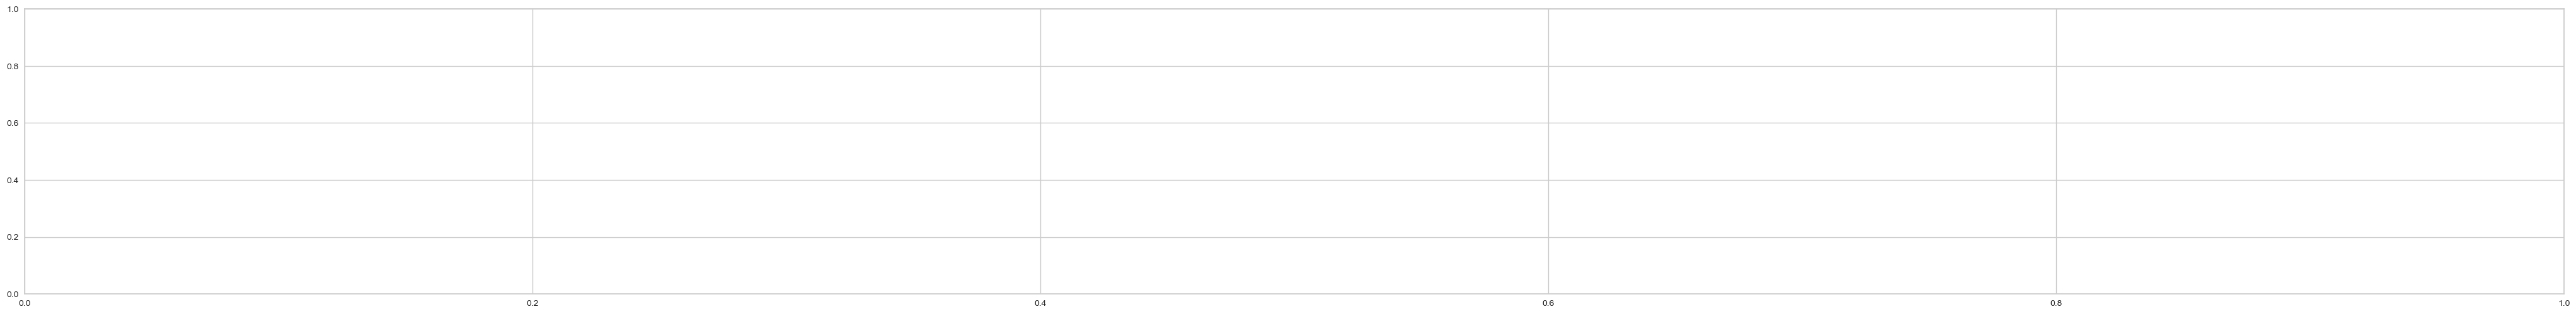

In [14]:
evaluate_model(cat)

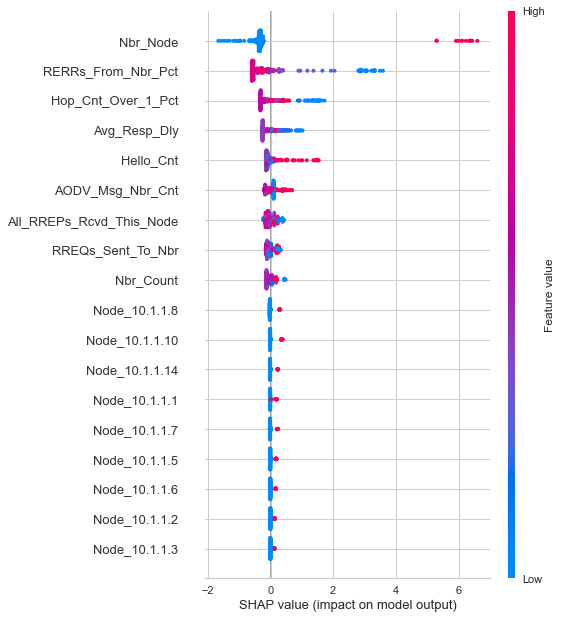

In [15]:
interpret_model(cat)

In [16]:
ds = predict_model(cat, test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9101,0.9334,0.0000,0.0000,0.0000,-0.0469,-0.0470


In [17]:
# check out prediction_label	prediction_score from the output table below
ds.head(10)

,Index,Node,Nbr_Node,Nbr_Count,Hello_Cnt,AODV_Msg_Nbr_Cnt,RREQs_Sent_To_Nbr,RREQs_From_Nbr,Nbr_Is_Orig_Cnt,Nbr_Never_Orig,...,High_Dest_Seq_Num_Inc_Pct,Avg_Resp_Dly,Avg_Resp_Dly_Per_Hop,RERRs_From_Nbr,RERRs_From_Nbr_Pct,Pct_of_All_Nbrs,RREP_To_Nbrs_Ratio,Black_Hole_Node,prediction_label,prediction_score
0,1,10.1.1.40,10.1.1.37,37.0,12.0,46.0,261.0,37.0,1.0,False,...,0.0,4.743225,0.458547,4.0,80.000000,2.7,0.251852,0,0,0.9993
1,2,10.1.1.40,10.1.1.3,37.0,19.0,0.0,261.0,0.0,0.0,True,...,NaN,NaN,NaN,0.0,NaN,2.7,0.000000,0,1,0.5200
2,3,10.1.1.40,10.1.1.5,37.0,41.0,34.0,261.0,18.0,0.0,True,...,0.0,3.986430,0.619930,2.0,14.290000,2.7,0.707407,0,0,0.9955
3,4,10.1.1.40,10.1.1.12,37.0,62.0,171.0,261.0,138.0,34.0,False,...,0.0,3.605955,0.588845,15.0,83.330002,2.7,0.911111,0,0,0.6441
4,5,10.1.1.40,10.1.1.41,37.0,133.0,433.0,261.0,239.0,1.0,False,...,0.0,2.620496,0.412112,82.0,73.209999,2.7,5.659259,0,0,0.9968
5,6,10.1.1.40,10.1.1.50,37.0,41.0,72.0,261.0,38.0,0.0,True,...,0.0,3.517327,0.468147,12.0,54.549999,2.7,1.111111,0,0,0.9993
6,7,10.1.1.40,10.1.1.34,37.0,9.0,44.0,261.0,33.0,0.0,True,...,0.0,2.655853,0.394568,6.0,120.000000,2.7,0.251852,0,0,0.9995
7,8,10.1.1.40,10.1.1.47,37.0,7.0,0.0,261.0,0.0,0.0,True,...,NaN,NaN,NaN,0.0,NaN,2.7,0.000000,0,0,0.9998
8,9,10.1.1.40,10.1.1.2,37.0,18.0,120.0,261.0,59.0,2.0,False,...,0.0,1.764827,0.362862,23.0,60.529999,2.7,1.918519,0,0,0.9995
9,10,10.1.1.40,10.1.1.45,37.0,26.0,265.0,261.0,0.0,0.0,True,...,100.0,3.236583,0.582365,0.0,0.000000,2.7,13.187813,1,0,0.9620


In [20]:
ds.to_csv("prediction_result.csv")

### It looks like this is not a good dataset for doing modeling, need to have actual or good simulation data